In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ALGORITHMS = {
    'B-I+S-2': 'Блюстейн + Стокхам (Итеративный, Бабочка-2)',
    'B-I+S-4': 'Блюстейн + Стокхам (Итеративный, Бабочка-4)',
    'CT-I+B+BRP+S-2': 'Кули-Тьюки (Итеративный, с Барьером, БОП, с Шагом, Бабочка-2)',
    'CT-I+B+DRP+S-4': 'Кули-Тьюки (Итеративный, с Барьером, ЦОП, с Шагом, Бабочка-4)',
    'CT-I+BRP+S-2': 'Кули-Тьюки (Итеративный, БОП, с Шагом, Бабочка-2)',
    'CT-I+DRP+S-4': 'Кули-Тьюки (Итеративный, ЦОП, с Шагом, Бабочка-4)',
    'CT-R+B+BRP-2': 'Кули-Тьюки (Рекурсивный, с Барьером, БОП, Бабочка-2)',
    'CT-R+B+DRP-4': 'Кули-Тьюки (Рекурсивный, с Барьером, ЦОП, Бабочка-4)',
    'CT-R+BRP-2': 'Кули-Тьюки (Рекурсивный, БОП, Бабочка-2)',
    'CT-R+DRP-4': 'Кули-Тьюки (Рекурсивный, ЦОП, Бабочка-4)',
    'CT-R+S-2': 'Кули-Тьюки (Рекурсивный, с Шагом, Бабочка-2)',
    'CT-R+S-4': 'Кули-Тьюки (Рекурсивный, с Шагом, Бабочка-4)',
    'CT-R-2': 'Кули-Тьюки (Рекурсивный, Бабочка-2)',
    'CT-R-4': 'Кули-Тьюки (Рекурсивный, Бабочка-4)',
    'GT-I+B+S-2': 'Гуд-Томас + Блюстейн + Стокхам (Итеративный, Бабочка-2)',
    'GT-I+DFT': 'Гуд-Томас + ДПФ',
    'S-I+TP-2': 'Стокхам (Итеративный, Пул потоков, Бабочка-2)',
    'S-I+TP-4': 'Стокхам (Итеративный, Пул потоков, Бабочка-4)',
    'S-I-2': 'Стокхам (Итеративный, Бабочка-2)',
    'S-I-4': 'Стокхам (Итеративный, Бабочка-4)',
    'S-R-2': 'Стокхам (Рекурсивный, Бабочка-2)',
    'S-R-4': 'Стокхам (Рекурсивный, Бабочка-4)'
}


def get_thread_description(thread: int) -> str:
    if thread == 1:
        return '1 поток'
    if thread in [2, 3, 4]:
        return f'{thread} потока'
    return f'{thread} потоков'


def get_algorithm_name(code: str) -> str:
    return ALGORITHMS[code]

In [3]:
plt.style.use('seaborn-v0_8')

In [4]:
BASE_FOLDER = Path('../output')
SIZE_COLUMN = 'Size'
THREAD_COLUMN = 'Thread'


@dataclass
class Benchmark:
    power: pd.DataFrame
    time: pd.DataFrame


def load(folder: str, filename: str, threads: list[int]) -> pd.DataFrame:
    data = []
    for thread in threads:
        file_path = BASE_FOLDER / folder / f'{filename}_{thread}.csv'
        if file_path.exists():
            dataframe = pd.read_csv(file_path, sep=';')
            dataframe[THREAD_COLUMN] = thread
            data.append(dataframe)
    return pd.concat(data)


def load_data(filename: str, threads: list[int]) -> Benchmark:
    return Benchmark(power=load('power', filename, threads), time=load('time', filename, threads))

In [5]:
def compare_radix_execution(benchmark: Benchmark,
                            radix2: str,
                            radix4: str,
                            threads: list[int],
                            size_labels: list[str]) -> None:
    """
    # Сравнение времени выполнения
    """
    colors = plt.cm.viridis(np.linspace(0, 1, len(threads)))

    plt.figure(figsize=(14, 8))

    for thread, color in zip(threads, colors):
        subset = benchmark.time[benchmark.time[THREAD_COLUMN] == thread]
        plt.loglog(subset[SIZE_COLUMN], subset[radix2], 'o-', color=color,
                   label=f'Бабочка-2, {get_thread_description(thread)}', alpha=0.7)
        plt.loglog(subset[SIZE_COLUMN], subset[radix4], 's--', color=color,
                   label=f'Бабочка-4, {get_thread_description(thread)}', alpha=0.7)

    sizes = benchmark.time[SIZE_COLUMN].unique()

    plt.title(f'Сравнение времени выполнения {get_algorithm_name(radix2)} и {get_algorithm_name(radix4)}')
    plt.xlabel('Размер массива')
    plt.ylabel('Время выполнения (сек)')
    plt.xticks(sizes, size_labels[: len(sizes)])
    plt.legend(ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def compare_radix_speedup(benchmark: Benchmark,
                          radix2: str,
                          radix4: str,
                          threads: list[int],
                          size_labels: list[str]) -> None:
    """
    Тепловая карта ускорения
    """
    plt.figure(figsize=(14, 8))

    speedup_matrix = []
    for thread in threads:
        subset = benchmark.time[benchmark.time[THREAD_COLUMN] == thread]
        speedup_matrix.append((subset[radix2] / subset[radix4]).values)

    sizes = benchmark.time[SIZE_COLUMN].unique()

    vmin = np.min(speedup_matrix) - 0.1
    vmax = np.max(speedup_matrix) + 0.1
    range25 = vmin + (vmax - vmin) * 0.25
    range75 = vmin + (vmax - vmin) * 0.75

    plt.imshow(speedup_matrix, cmap='RdYlGn', vmin=vmin, vmax=vmax, aspect='auto')
    plt.colorbar(label='Ускорение')
    plt.yticks(range(len(threads)), threads)
    plt.xticks(range(len(sizes)), size_labels[: len(sizes)])
    plt.title(f'Ускорение {get_algorithm_name(radix4)} по сравнению с {get_algorithm_name(radix2)}')
    plt.xlabel('Размер массива')
    plt.ylabel('Количество потоков')

    # Аннотации
    for i in range(len(threads)):
        for j in range(len(sizes)):
            plt.text(j, i, f'{speedup_matrix[i][j]:.2f}x', fontsize=16, ha='center', va='center',
                     color='black' if range25 < speedup_matrix[i][j] < range75 else 'white')

    plt.tight_layout()
    plt.show()


def compare_radix(filename: str, radix2: str, radix4: str, threads: list[int]) -> None:
    benchmark = load_data(filename, threads)
    size_labels = ['256', '1K', '4K', '16K', '64K', '256K', '1M', '4M', '16M']

    compare_radix_execution(benchmark, radix2, radix4, threads, size_labels)
    compare_radix_speedup(benchmark, radix2, radix4, threads, size_labels)

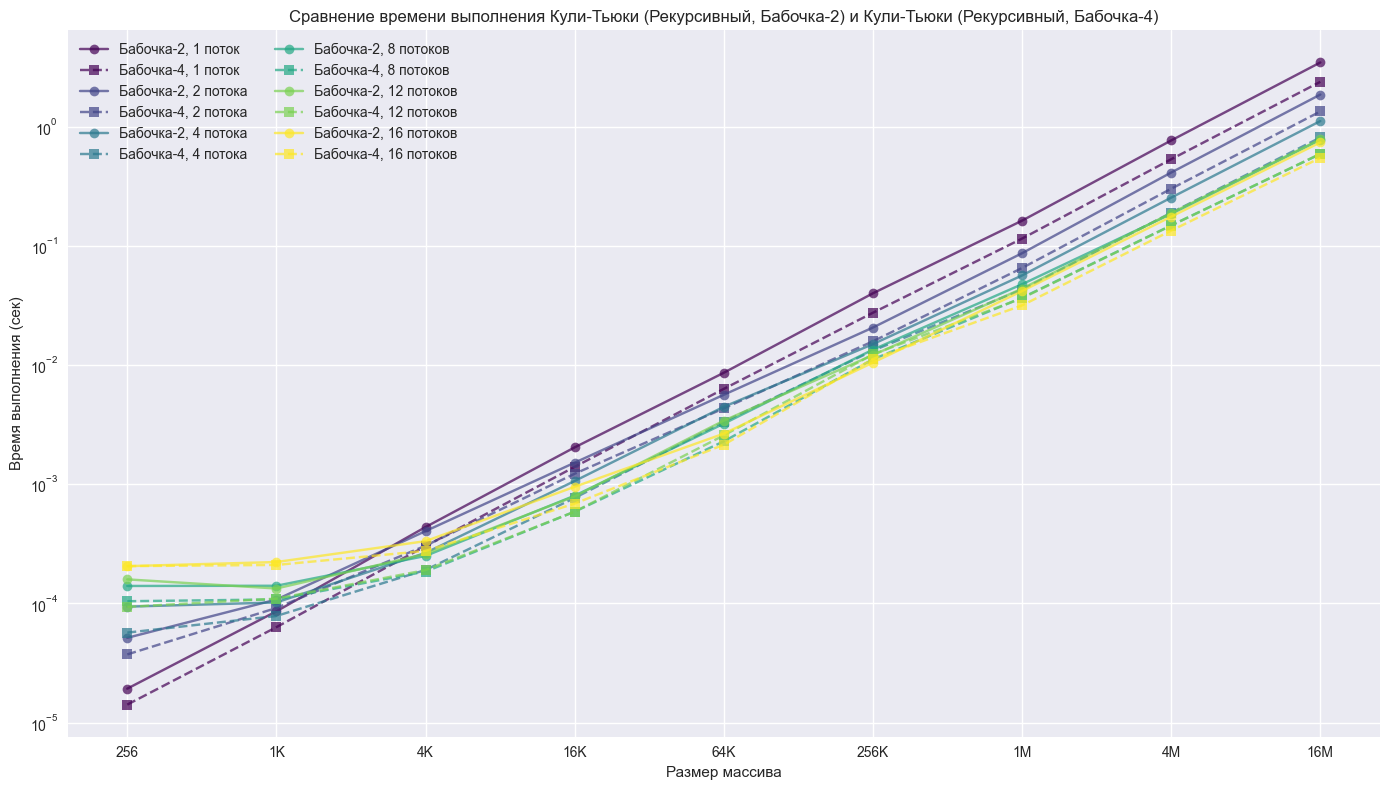

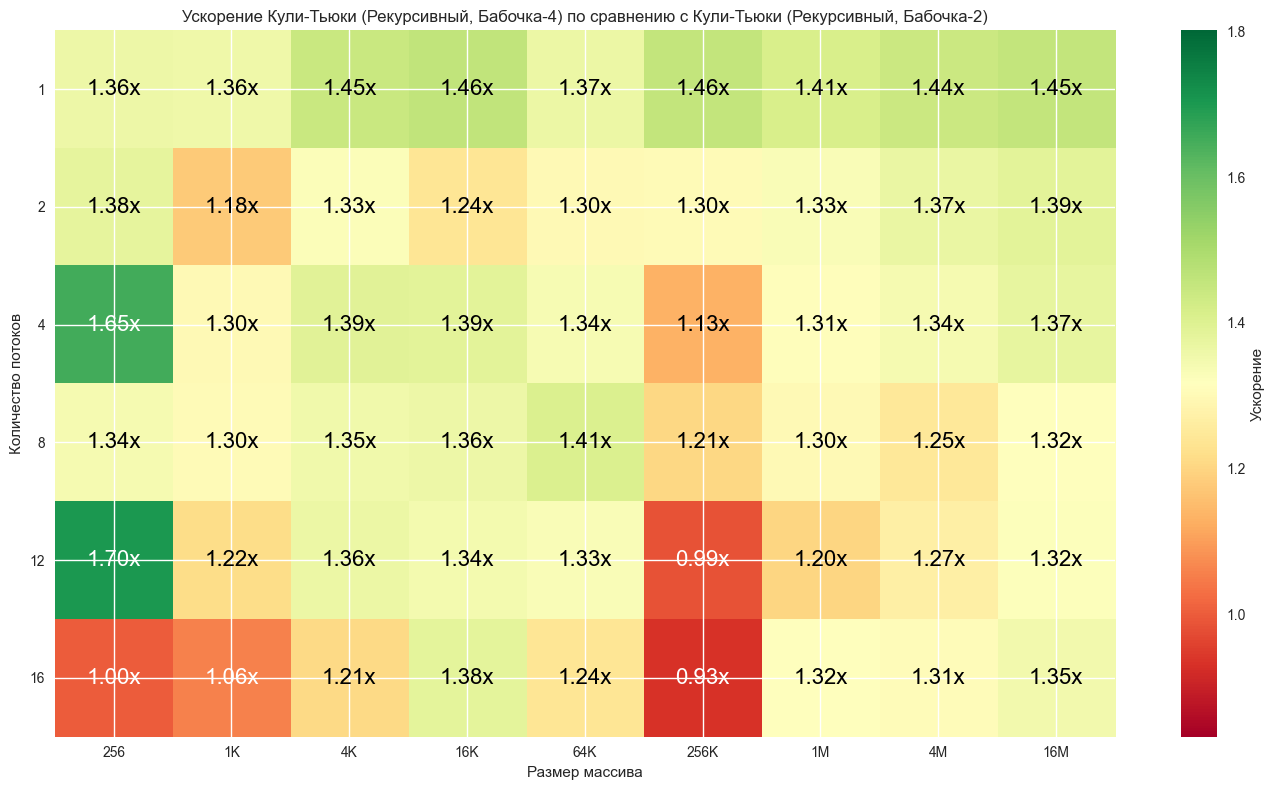

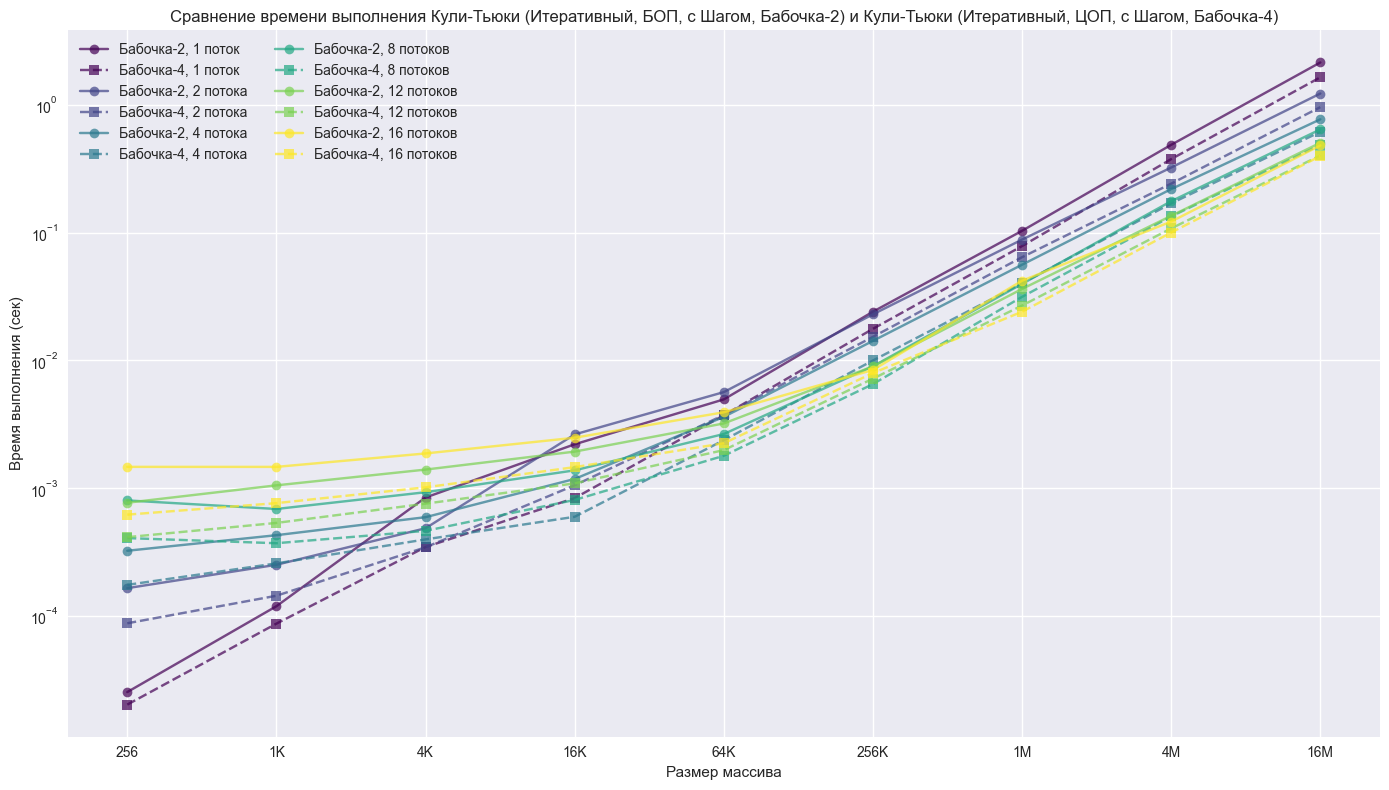

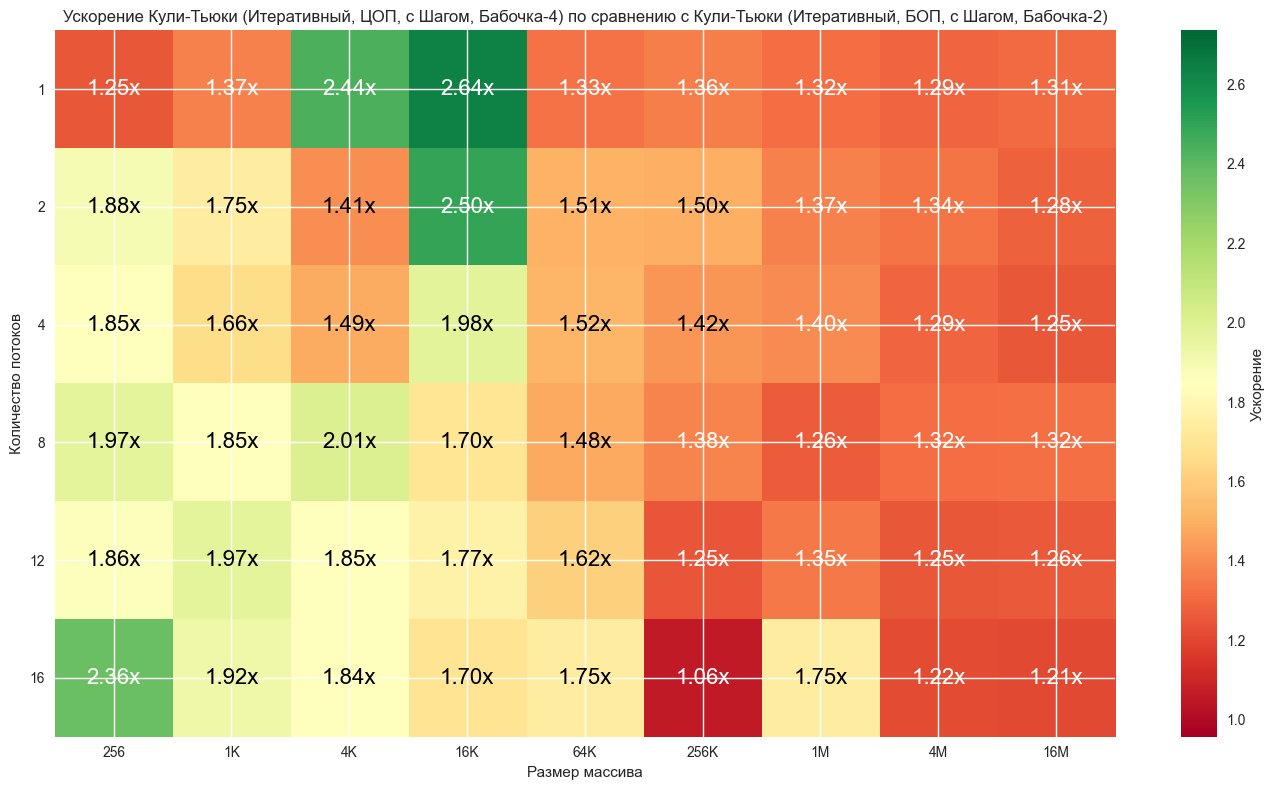

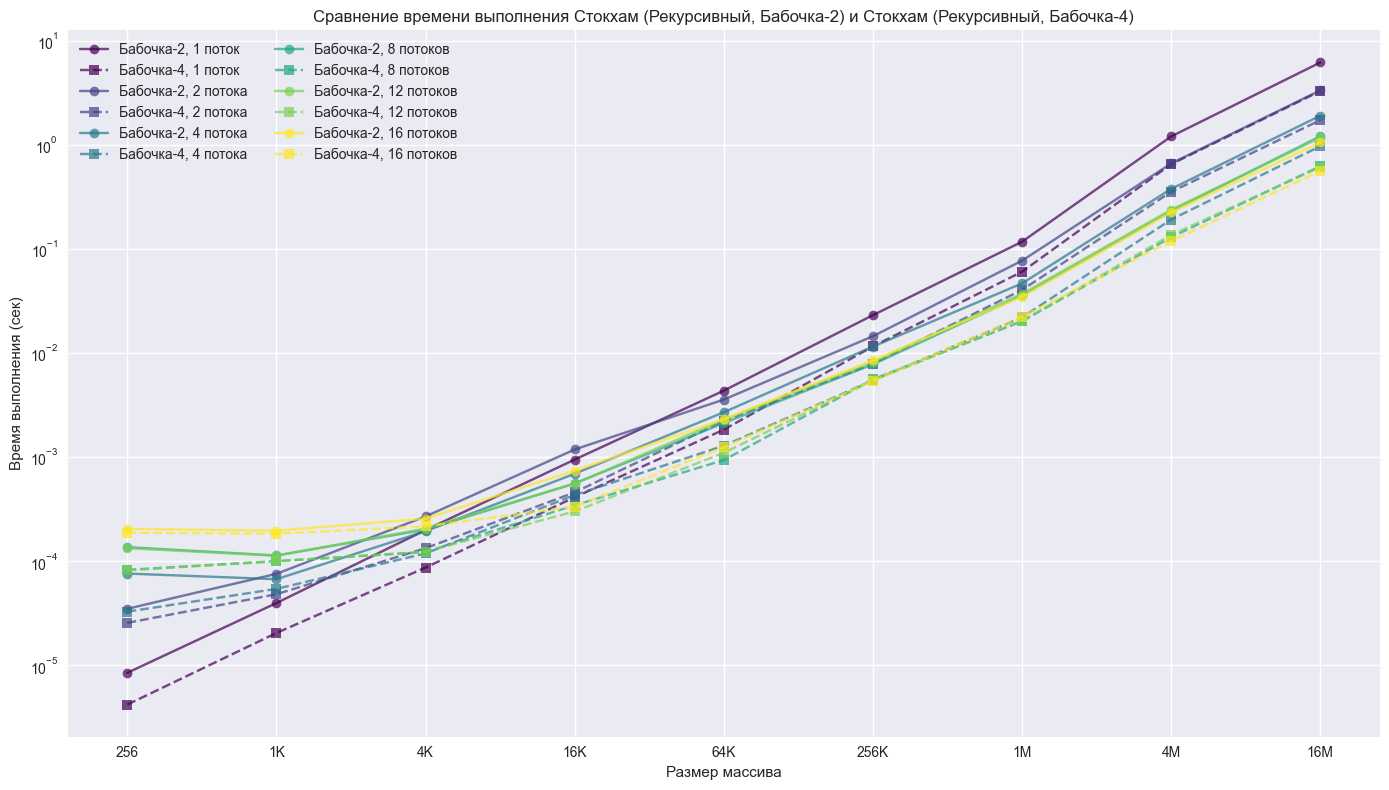

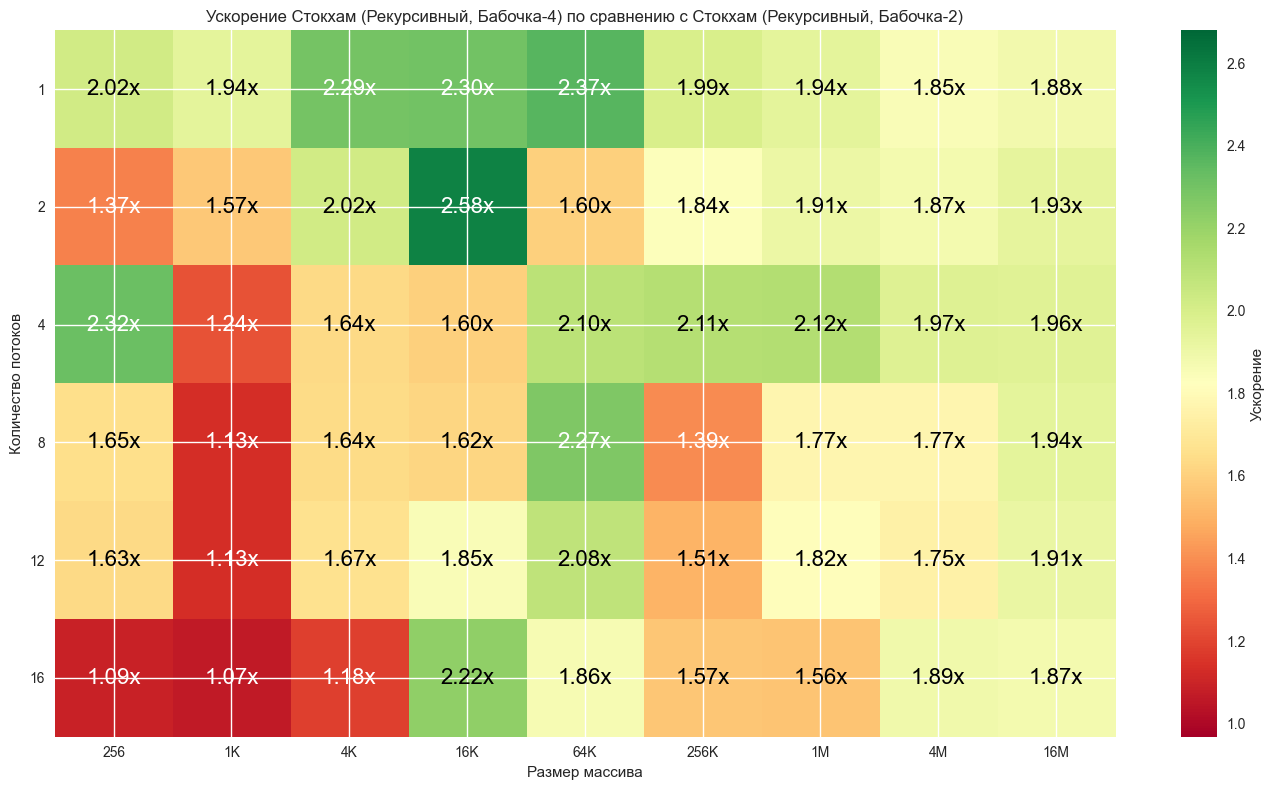

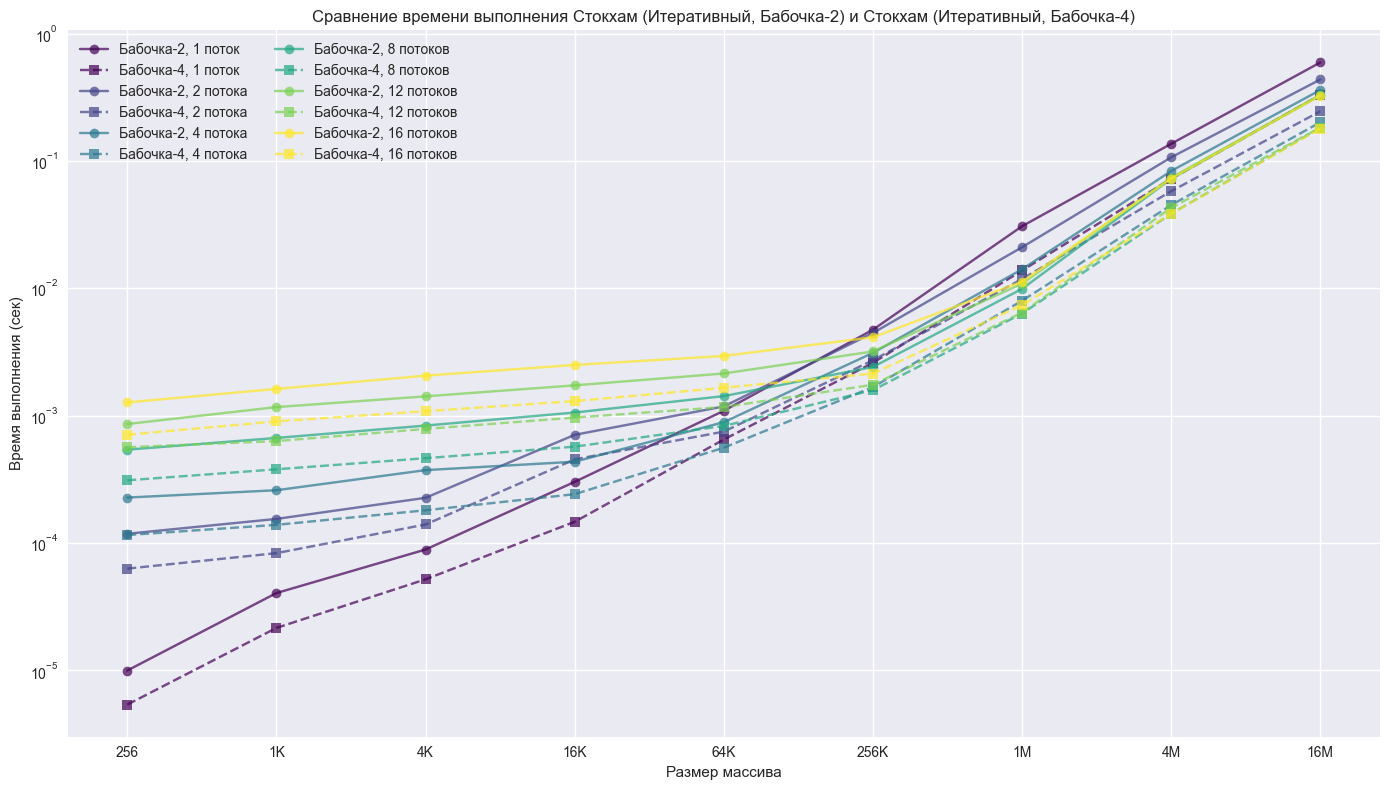

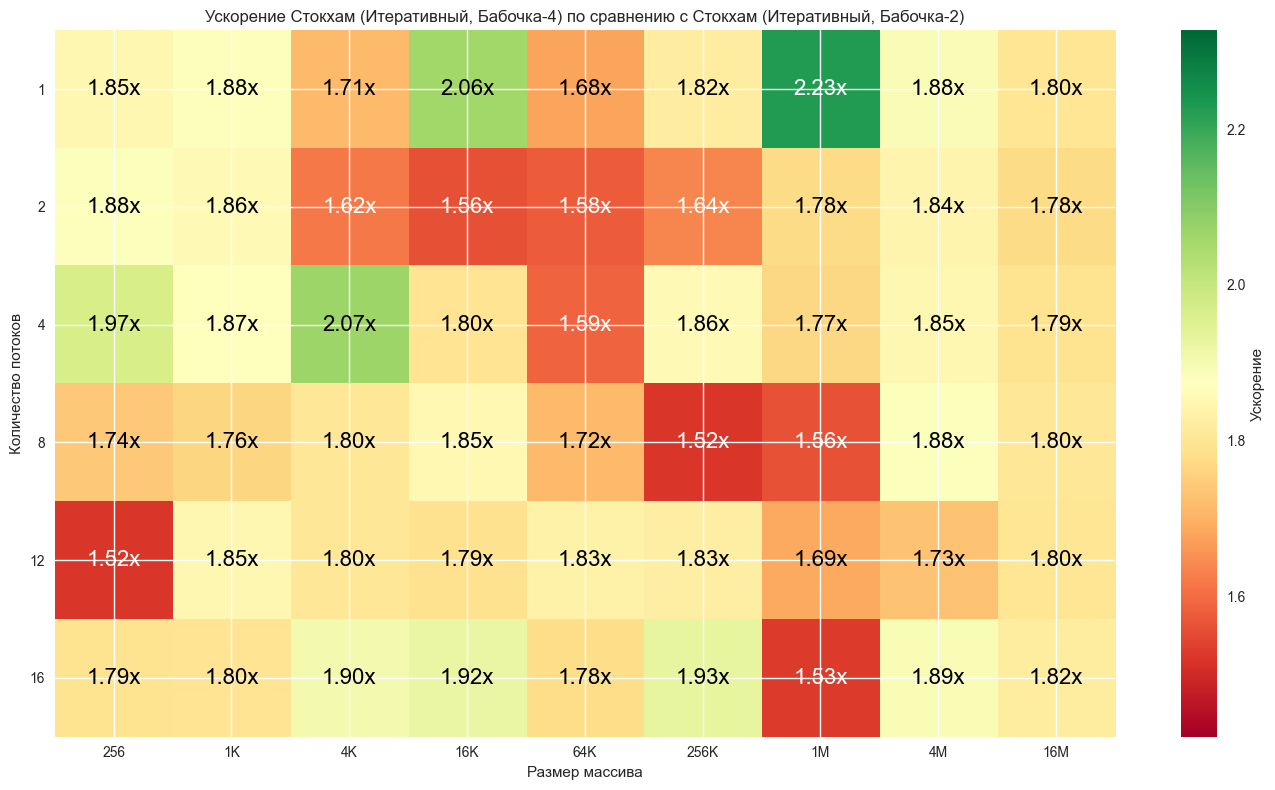

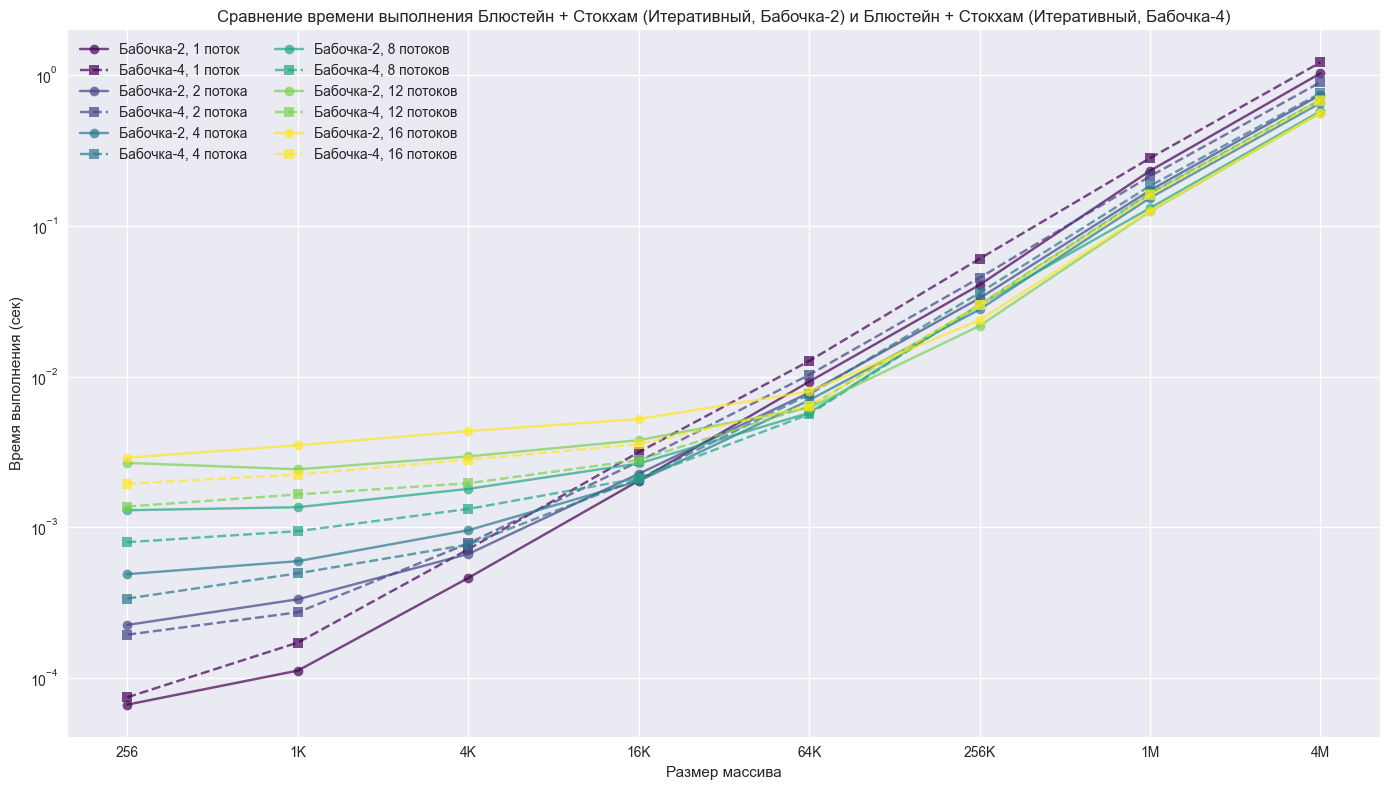

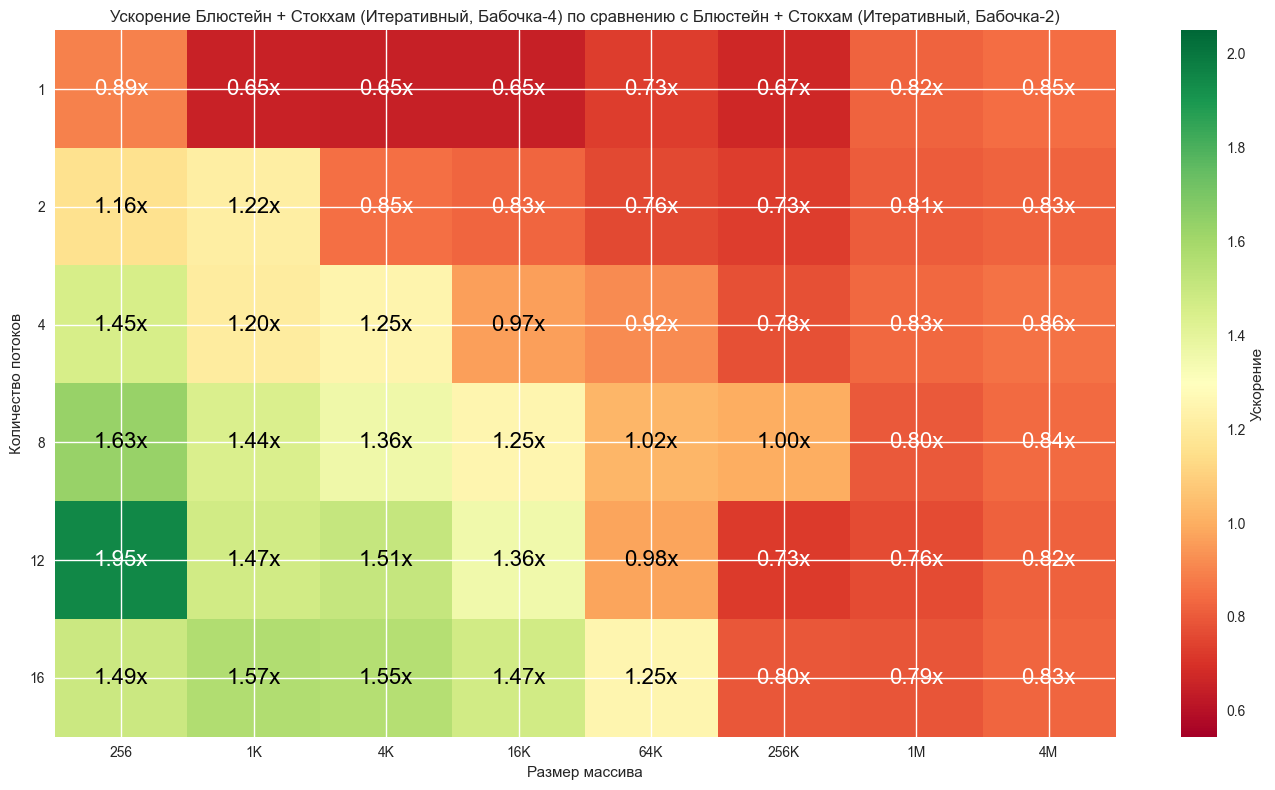

In [6]:
compare_radix('radix_r_cooley-tukey', 'CT-R-2', 'CT-R-4', threads=[1, 2, 4, 8, 12, 16])
compare_radix('radix_i_cooley-tukey', 'CT-I+BRP+S-2', 'CT-I+DRP+S-4', threads=[1, 2, 4, 8, 12, 16])
compare_radix('radix_r_stockham', 'S-R-2', 'S-R-4', threads=[1, 2, 4, 8, 12, 16])
compare_radix('radix_i_stockham', 'S-I-2', 'S-I-4', threads=[1, 2, 4, 8, 12, 16])
compare_radix('radix_bluestein-stockham', 'B-I+S-2', 'B-I+S-4', threads=[1, 2, 4, 8, 12, 16])